In [0]:
%tensorflow_version 1.15
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 1000
batch_size = 128

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
def load_data(file):
  with open(file, 'rb') as fo:
      try:
          samples = pickle.load(fo)
      except UnicodeDecodeError:  # python 3.x
          fo.seek(0)
          samples = pickle.load(fo, encoding='latin1')

  data, labels = samples['data'], samples['labels']

  data = np.array(data, dtype=np.float32)
  labels = np.array(labels, dtype=np.int32)

  labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
  labels_[np.arange(labels.shape[0]), labels - 1] = 1

  return data, labels_

In [0]:
def cnn(images):
  images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

  # Conv 1
  W_conv1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, 50], stddev=1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)),
                   name='weights_1')
  b_conv1 = tf.Variable(tf.zeros([50]), name='biases_1')

  h_conv_1 = tf.nn.relu(tf.nn.conv2d(images, W_conv1, [1, 1, 1, 1], padding='VALID') + b_conv1)
  h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_1')

  # Conv 2
  W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 50, 60], stddev=1.0 / np.sqrt(50 * 5 * 5)),
                   name='weights_2')
  b_conv2 = tf.Variable(tf.zeros([60]), name='biases_2')

  h_conv_2 = tf.nn.relu(tf.nn.conv2d(h_pool_1, W_conv2, [1, 1, 1, 1], padding='VALID') + b_conv2)
  h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_2')

  
  dim = h_pool_2.get_shape()[1].value * h_pool_2.get_shape()[2].value * h_pool_2.get_shape()[3].value
  # FC 1
  W_fc_1 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0 / np.sqrt(dim)),
                   name='weights_3')
  b_fc_1 = tf.Variable(tf.zeros([300]), name='biases_3')
  
  pool_2_flat = tf.reshape(h_pool_2, [-1, dim])
  h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc_1) + b_fc_1)
  
  # Softmax
  W_fc_2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0 / np.sqrt(300)), name='weights_4')
  b_fc_2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
  logits = tf.matmul(h_fc1, W_fc_2) + b_fc_2

  keep_prob = 1

  return W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob

In [0]:
trainX, trainY = load_data('./data_batch_1')
testX, testY = load_data('./test_batch_trim')
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

trainX = (trainX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
testX = (testX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)

N = len(trainX)
idx = np.arange(N)

# shuffle data
np.random.shuffle(idx)
trainX, trainY = trainX[idx], trainY[idx]

validationX = trainX[9000:, :]
validationY = trainY[9000:, :]
trainX = trainX[:9000, :]
trainY = trainY[:9000, :]

# sanity check
print(validationX.shape); print(validationY.shape)
print(trainX.shape); print(trainY.shape)

(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
(1000, 3072)
(1000, 10)
(9000, 3072)
(9000, 10)


Epoch 0: Train Cost = 2.2982022762298584, Test Acc = 0.09950000047683716
Epoch 100: Train Cost = 1.8386423587799072, Test Acc = 0.3345000147819519
Epoch 200: Train Cost = 1.6816599369049072, Test Acc = 0.36899998784065247
Epoch 300: Train Cost = 1.5465707778930664, Test Acc = 0.3564999997615814
Epoch 400: Train Cost = 1.453341007232666, Test Acc = 0.36399999260902405
Epoch 500: Train Cost = 1.3685948848724365, Test Acc = 0.37549999356269836
Epoch 600: Train Cost = 1.2899125814437866, Test Acc = 0.39100000262260437
Epoch 700: Train Cost = 1.205153226852417, Test Acc = 0.3804999887943268
Epoch 800: Train Cost = 1.1405266523361206, Test Acc = 0.36250001192092896
Epoch 900: Train Cost = 1.073104977607727, Test Acc = 0.3400000035762787


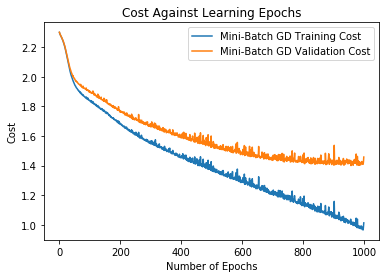

<Figure size 432x288 with 0 Axes>

In [0]:
  # Create the model
  x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
  y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

  W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob = cnn(x)

  cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
  loss = tf.reduce_mean(cross_entropy)

  train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
  correct_prediction = tf.cast(correct_prediction, tf.float32) # Cast to float
  accuracy = tf.reduce_mean(correct_prediction)

  N = len(trainX)
  idx = np.arange(N)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_cost = []
    test_acc = []
    validation_cost = []
    for e in range(epochs):
      np.random.shuffle(idx)
      trainX, trainY = trainX[idx], trainY[idx]

      for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
        train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

      train_cost.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
      test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
      validation_cost.append(loss.eval(feed_dict={x: validationX, y_: validationY}))

      if e%100 == 0:
        print('Epoch {}: Train Cost = {}, Test Acc = {}'.format(e, train_cost[e], test_acc[e]))
 
    plt.figure(1)
    plt.plot(range(epochs), train_cost, label='Mini-Batch GD Training Cost')
    plt.plot(range(epochs), validation_cost, label='Mini-Batch GD Validation Cost')
    plt.xlabel('Number of Epochs')
    plt.legend()
    plt.ylabel('Cost')
    plt.title("Cost Against Learning Epochs")
    plt.show()
    plt.savefig('./1a_train_cost.png')

(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.296889543533325, Test Acc = 0.125
Epoch 100: Train Cost = 1.823188304901123, Test Acc = 0.3330000042915344
Epoch 200: Train Cost = 1.6549593210220337, Test Acc = 0.33500000834465027
Epoch 300: Train Cost = 1.54976224899292, Test Acc = 0.2904999852180481
Epoch 400: Train Cost = 1.4435980319976807, Test Acc = 0.38499999046325684
Epoch 500: Train Cost = 1.3406178951263428, Test Acc = 0.3580000102519989
Epoch 600: Train Cost = 1.2432317733764648, Test Acc = 0.39100000262260437
Epoch 700: Train Cost = 1.1679930686950684, Test Acc = 0.3804999887943268


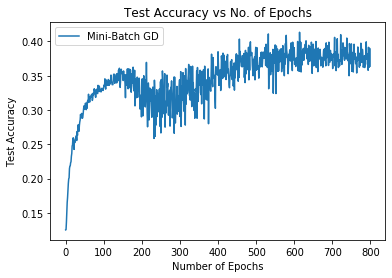

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

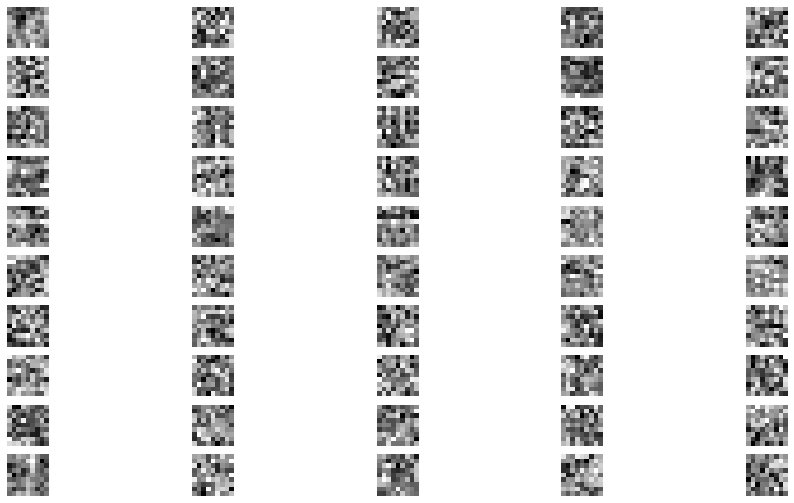

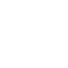

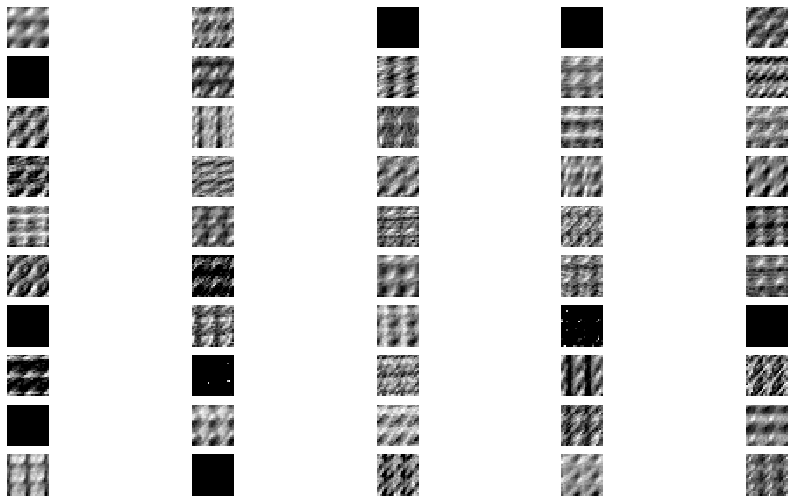

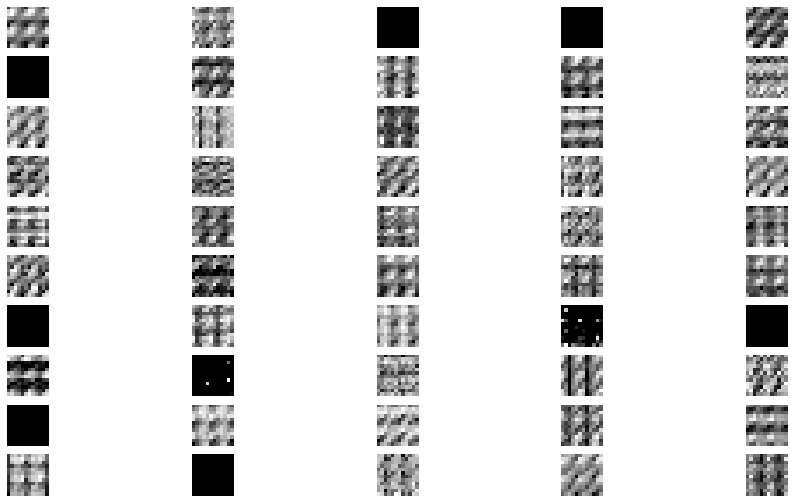

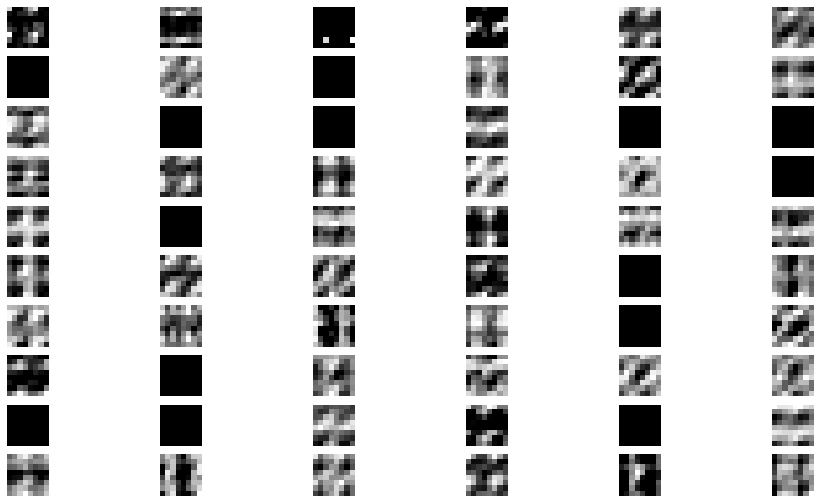

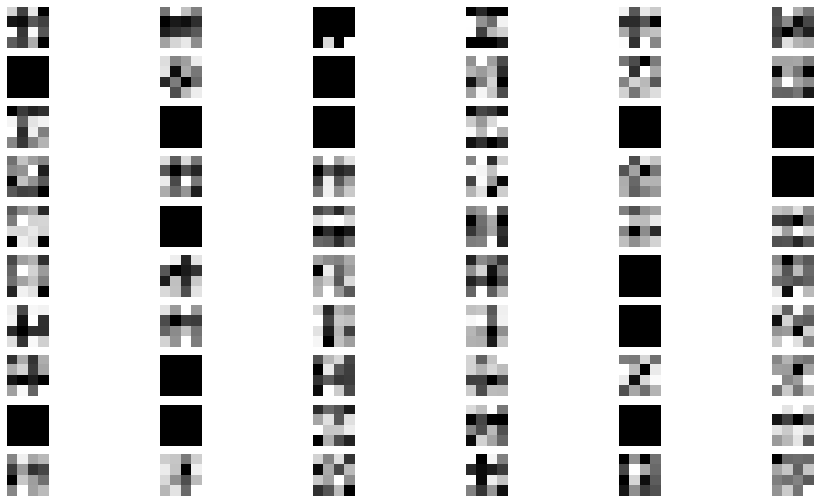

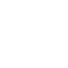

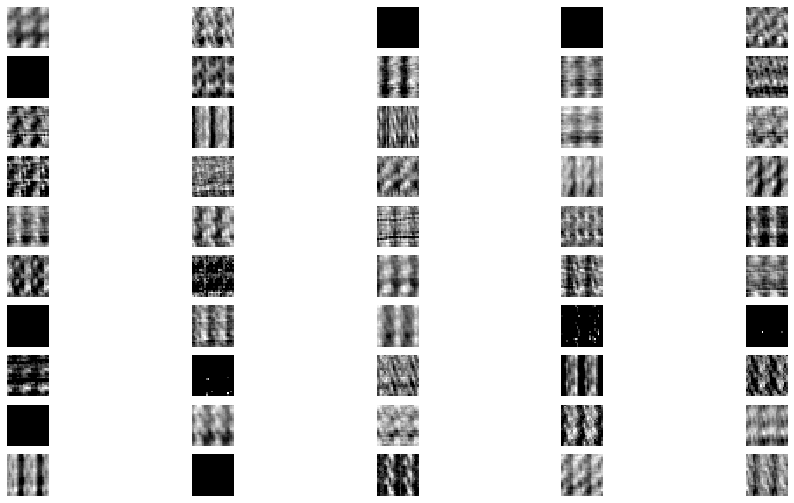

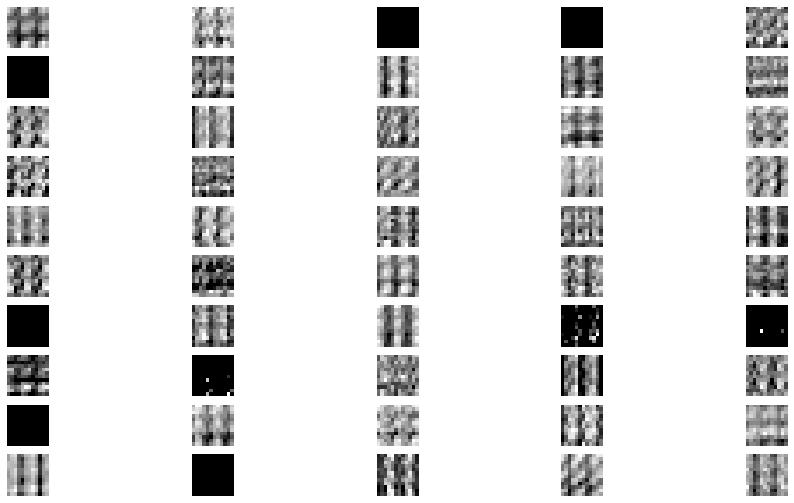

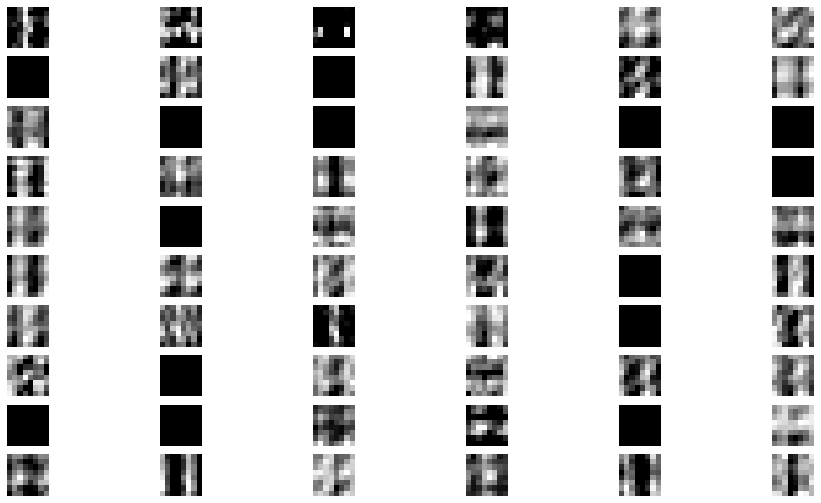

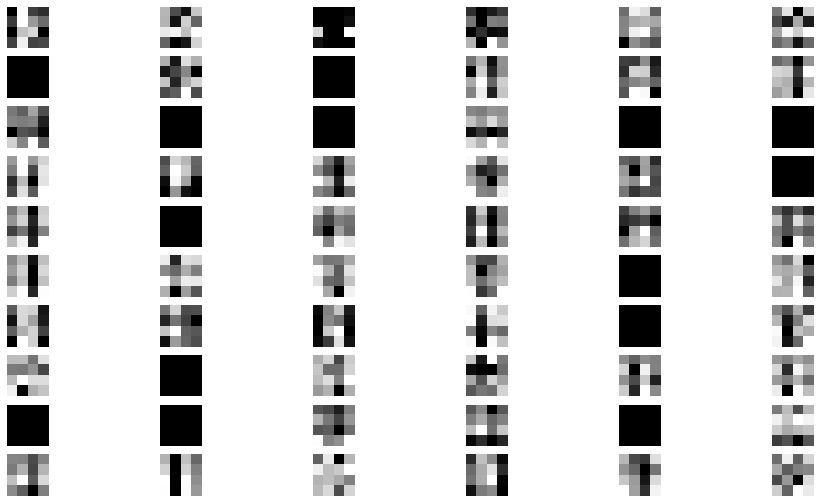

In [0]:
trainX, trainY = load_data('data_batch_1')
print(trainX.shape, trainY.shape)

testX, testY = load_data('test_batch_trim')
print(testX.shape, testY.shape)

trainX = (trainX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
testX = (testX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)

epochs = 800

# just discovered this LOL
# enable GPU device in Colab's setting then you can use this
# it makes training 100x faster
with tf.device('/device:GPU:0'):

  # Create the model
  x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
  y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

  W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob = cnn(x)

  cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
  loss = tf.reduce_mean(cross_entropy)

  train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
  correct_prediction = tf.cast(correct_prediction, tf.float32) # Cast to float
  accuracy = tf.reduce_mean(correct_prediction)

  N = len(trainX)
  idx = np.arange(N)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_cost = []
    test_acc = []
    validation_cost = []
    for e in range(epochs):
      np.random.shuffle(idx)
      trainX, trainY = trainX[idx], trainY[idx]

      for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
        train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

      train_cost.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
      test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
      validation_cost.append(loss.eval(feed_dict={x: validationX, y_: validationY}))

      if e%100 == 0:
        print('Epoch {}: Train Cost = {}, Test Acc = {}'.format(e, train_cost[e], test_acc[e]))

    plt.figure(2)
    plt.plot(range(epochs), test_acc, label='Mini-Batch GD')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Test Accuracy')
    plt.title("Test Accuracy vs No. of Epochs")
    plt.legend()
    plt.show()
    plt.savefig('./figures/1a_test_acc.png')
    
    W_conv1_ = sess.run(W_conv1)
    W_conv1_ = np.array(W_conv1_)
    fig = plt.figure(3)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    plt.gray()
    for i in range(50):
      plt.subplot(10, 5, i+1); plt.axis('off'); plt.imshow(W_conv1_[:,:,0,i])
    plt.savefig('./figures/1a_conv1_weight.png')
    
    ind1 = np.random.randint(low=0, high=1000)
    X1 = testX[273, :]
    ind2 = np.random.randint(low=1000, high=2000)
    X2 = testX[1033, :]

    fig = plt.figure(4)
    fig.set_figheight(1)
    fig.set_figwidth(1)
    plt.axis('off')
    plt.imshow(X1.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0))
    plt.savefig('./figures/p1b_1.png')
    
    h_conv_1_, h_pool_1_ = sess.run([h_conv_1, h_pool_1], {x: X1.reshape(1,IMG_SIZE*IMG_SIZE*NUM_CHANNELS)})
    h_conv_2_, h_pool_2_ = sess.run([h_conv_2, h_pool_2], {x: X1.reshape(1,IMG_SIZE*IMG_SIZE*NUM_CHANNELS)})
    
    fig = plt.figure(5)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    h_conv_1_ = np.array(h_conv_1_)
    for i in range(50):
      plt.subplot(10, 5, i+1)
      plt.axis('off')
      plt.imshow(h_conv_1_[0,:,:,i])
    plt.savefig('./figures/p1b_1_conv1.png')
    
    fig = plt.figure(6)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    h_pool_1_ = np.array(h_pool_1_)
    for i in range(50):
      plt.subplot(10, 5, i+1); plt.axis('off'); plt.imshow(h_pool_1_[0,:,:,i])
    plt.savefig('./figures/p1b_1_s1.png')
    
    fig = plt.figure(7)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    h_conv_2_ = np.array(h_conv_2_)
    for i in range(60):
      plt.subplot(10, 6, i+1); plt.axis('off'); plt.imshow(h_conv_2_[0,:,:,i])
    plt.savefig('./figures/p1b_1_conv2.png')
    
    fig = plt.figure(8)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    h_pool_2_ = np.array(h_pool_2_)
    for i in range(60):
      plt.subplot(10, 6, i+1); plt.axis('off'); plt.imshow(h_pool_2_[0,:,:,i])
    plt.savefig('./figures/p1b_1_s2.png')
    
    
    fig = plt.figure(9)
    fig.set_figheight(1)
    fig.set_figwidth(1)
    plt.axis('off')
    plt.imshow(X2.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0))
    plt.savefig('./figures/p1b_2.png')
    
    h_conv_1_, h_pool_1_ = sess.run([h_conv_1, h_pool_1], {x: X2.reshape(1,IMG_SIZE*IMG_SIZE*NUM_CHANNELS)})
    h_conv_2_, h_pool_2_ = sess.run([h_conv_2, h_pool_2], {x: X2.reshape(1,IMG_SIZE*IMG_SIZE*NUM_CHANNELS)})
    
    fig = plt.figure(10)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    h_conv_1_ = np.array(h_conv_1_)
    for i in range(50):
      plt.subplot(10, 5, i+1)
      plt.axis('off')
      plt.imshow(h_conv_1_[0,:,:,i])
    plt.savefig('p1b_2_c1.png')
    
    fig = plt.figure(11)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    h_pool_1_ = np.array(h_pool_1_)
    for i in range(50):
      plt.subplot(10, 5, i+1); plt.axis('off'); plt.imshow(h_pool_1_[0,:,:,i])
    plt.savefig('p1b_2_s1.png')
    
    fig = plt.figure(12)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    h_conv_2_ = np.array(h_conv_2_)
    for i in range(60):
      plt.subplot(10, 6, i+1); plt.axis('off'); plt.imshow(h_conv_2_[0,:,:,i])
    plt.savefig('p1b_2_c2.png')
    
    fig = plt.figure(13)
    fig.set_figheight(9)
    fig.set_figwidth(16)
    h_pool_2_ = np.array(h_pool_2_)
    for i in range(60):
      plt.subplot(10, 6, i+1); plt.axis('off'); plt.imshow(h_pool_2_[0,:,:,i])
    plt.savefig('p1b_2_s2.png')